# Guided mode expansion of a PhC slab with vertical (kz) symmetry plane

In this example we apply `legume` to calculate the bands of a PhC slab with vertical (kz) mirror planes, i.e., vertical planes that are defined by the wavevector ${\bf k}$ and the $z$ axis. Such plane exist in symmetric lattices (like the square and hexagonal lattice) only along some symmetry-directions in k-space. This example is related to Sec. 3.1 of the CPC paper.

This feature is new to Legume 1.0 (2024 version, CPC paper).

In [1]:
import legume
print(f"Version of the imported legume : {legume.__version__}")

import numpy as np
import matplotlib.pyplot as plt
import copy

Version of the imported legume : 1.0.0


## Define a PhC slab with a square lattice

We adopt the parameters of Fig. 6(b) of the CPC paper


In [2]:
D = 0.5          # slab thickness in units of a
r = 0.2          # hole radius in units of a
eps_c = 1        # dielectric constant of circular hole
eps_b = 3.54**2  # background dielectric constant of slab
eps_lower, eps_upper = 1.45**2, 1  # dielectric constants of lower and upper claddings

lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=D, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))
gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')

## Calulate even and odd mode with respect to the vertical plane of symmetry

Here we exploit a new feature in legume 1.0, namely symmetry (or parity) separation with respect to reflection $\sigma_{kz}$ in a vertical mirror plane that contains the 2D wavevector ${\bf k}$. This mirror symmetry holds only along special symmetry directions of the lattice, e.g, the $\Gamma-\text{X}$ and $\Gamma-\text{M}$ directions of the square lattice, and the $\Gamma-\text{K}$ and $\Gamma-\text{M}$ directions of the triangular lattice.

Symmetry separation is controlled by the keyword argument `symmetry` which can have four values:
* `symmetry = None`: no symmetry separation (in this case it is not a string)
* `symmetry = 'even'`: only modes with $\sigma_{kz}=+1$ are calculated
* `symmetry = 'odd'`:  only modes with $\sigma_{kz}=-1$ are calculated
* `symmetry = 'both'`: both modes with $\sigma_{kz}=+1$ and with $\sigma_{kz}=-1$ are calculated separately

In [3]:
path = lattice.bz_path(['X', 'G', 'M'], [50, 80])
gmode_inds, numeig, verbose, compute_im = [0, 1, 2, 3], 40, True, False
gmax = 5.5

gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='even',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_even = gme.freqs

gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='odd',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_odd = gme.freqs
(X0,X) = legume.viz.calculate_x(path["kpoints"],numeig,k_units=True) # Create an array for bands plotting

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 97 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 7.229    │ │██████████----------│   53% │
│ Inverse matrix of Fourier-space permittivity              │ 0.002    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.417    │ │--------------------│    3% │
│ Creating GME matrix                                       │ 4.272    │ │██████--------------│   31% │
│ Creating change of basis matrix using dense matrices      │ 1.632    │ │██------------------│   12% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 131 k-points  │ 13.612   │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 97 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 7.453    │ │██████████----------│   53% │
│ Inverse matrix of Fourier-space permittivity              │ 0.001    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.426    │ │--------------------│    3% │
│ Creating GME matrix                                       │ 4.412    │ │██████--------------│   31% │
│ Creating change of basis matrix using dense matrices      │ 1.668    │ │██------------------│   12% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 131 k-points  │ 14.021   │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

Define light lines for the plot

In [4]:
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]
light_lower_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[0])
light_upper_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[1])

Plot the photonic bands with even/odd separation

(0.0, 0.36)

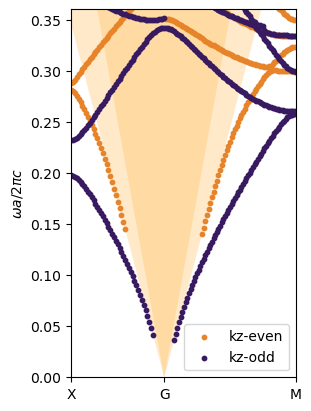

In [5]:
markersize = 10
ymin, ymax = 0, 0.36
odd_color = "#381a61"
even_color = "#E78429"
both_color = "#AB3329"

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(3, 4))

ax.scatter(X, freqs_even,c=even_color, s=markersize, label='kz-even')
ax.scatter(X, freqs_odd, c=odd_color, s=markersize, label='kz-odd')
ax.set_xlim([0, 1])

ax.fill_between(X0, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
ax.fill_between(X0, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
ax.legend()
ax.set_ylabel("$\omega a/2\pi c$")
ax.set_xticks(path['k_indexes'], path['labels'])
ax.set_ylim([ymin, ymax])

## Compare separated and not-separated bands

We can compare with the bands without symmetry separation (like in the original versione of legume, using the option `kz_symmetry=None`.
Also, we can calculate bands of both parities in one shot using the option  `kz_symmetry='both'`. This is faster than calculating even and odd modes separately, but we have to extract the results in the proper way.

In [6]:
gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry=None,
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_none = gme.freqs

gme = legume.GuidedModeExp(phc, gmax=gmax, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='both',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_both = gme.freqs
kz_symms = gme.kz_symms  # this is the array that contains the parities of the modes: +1 for even, -1 for odd


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 97 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 8.251    │ │███████████---------│   58% │
│ Inverse matrix of Fourier-space permittivity              │ 0.001    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 1.234    │ │█-------------------│    9% │
│ Creating GME matrix                                       │ 4.623    │ │██████--------------│   33% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 131 k-points  │ 14.172   │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 97 plane waves and 4 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'       │ 8.021    │ │██████████----------│   53% │
│ Inverse matrix of Fourier-space permittivity              │ 0.001    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver           │ 0.828    │ │█-------------------│    5% │
│ Creating GME matrix                                       │ 4.565    │ │██████--------------│   30% │
│ Creating change of basis matrix using dense matrices      │ 1.724    │ │██------------------│   11% │
├───────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 131 k-points  │ 15.202   │ │████████████████████│  100% │
└───────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

Here we separate the array freqs into even and odd frequencies


In [7]:
freqs_both_even = copy.deepcopy(freqs_both)
freqs_both_even[kz_symms==-1] = None
freqs_both_odd = copy.deepcopy(freqs_both)
freqs_both_odd[kz_symms==1] = None

In [8]:
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]
light_lower_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[0])
light_upper_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[1])

Text(0.5, 1.0, 'violet=even,  orange=odd')

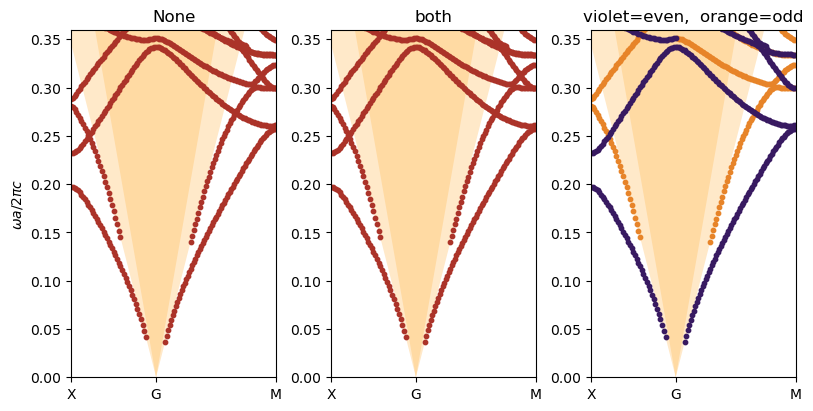

In [9]:

ymin, ymax = 0, 0.36

fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(8, 4))
for a in ax: # Loop over all axis for common set-up (limits, lightcones,...)
  a.set_xlim([0, 1])
  a.fill_between(X0, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
  a.fill_between(X0, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
  a.set_xticks(path['k_indexes'])
  a.set_xticklabels(path['labels'])
  a.set_ylim([ymin, ymax])

ax[0].scatter(X, freqs_none, c=both_color, s=markersize)
ax[0].set_title('None')
ax[0].set_ylabel("$\omega a/2\pi c$")
ax[1].scatter(X, freqs_both,c=both_color, s=markersize)
ax[1].set_title('both')

ax[2].scatter(X, freqs_both_even, c=even_color, s=markersize)
ax[2].scatter(X, freqs_both_odd, c=odd_color, s=markersize)
ax[2].set_title('violet=even,  orange=odd')